## Create a Bagging Regressor model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor


#from sktime.forecasting import arima
%load_ext autoreload 
%autoreload 2
import functions as fun

In [2]:
# load the dataset
dataset = pd.read_csv('training_data.csv')
# dropp unncecassary columns
dataset = dataset.drop(['Unnamed: 0'], axis = 1)
dataset.head()

,epoch_utc,emission_factor,datetime_de,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,...,DK_import,DK_export,LU_import,LU_export,NL_import,NL_export,PL_import,PL_export,CH_import,CH_export
0,1.546297e+09,298.240217,2018-12-31 23:00:00+00:00,18879.75,5069.00,0.0,28.32,57054.0,61.0,4940.0,...,901.0,0.0,12.0,418.0,0.0,1354.0,224.0,0.0,0.0,800.0
1,1.546301e+09,266.522473,2019-01-01 00:00:00+00:00,20626.50,5042.25,0.0,10.07,57400.0,60.0,5073.0,...,316.0,0.0,16.0,398.0,0.0,1158.0,0.0,0.0,1.0,801.0
2,1.546304e+09,262.594215,2019-01-01 01:00:00+00:00,22355.50,5028.50,0.0,-4.08,57275.0,20.0,4284.0,...,0.0,405.0,19.0,379.0,0.0,1176.0,0.0,0.0,0.0,800.0
3,1.546308e+09,260.190772,2019-01-01 02:00:00+00:00,24032.50,4977.75,0.0,-9.91,58024.0,3.0,4273.0,...,0.0,619.0,23.0,373.0,0.0,1428.0,0.0,0.0,0.0,800.0
4,1.546312e+09,250.496683,2019-01-01 03:00:00+00:00,25452.00,4907.25,0.0,-7.41,59301.0,0.0,4961.0,...,0.0,689.0,27.0,370.0,0.0,1492.0,0.0,0.0,0.0,800.0


In [3]:
# Split dataset int targe = co2 emisssions and features

# get co2 emissions
co2 = dataset['emission_factor']

# get features
cols_features = [c for c in dataset.columns if c != 'emission_factor']
cols = {c: i for i, c in enumerate(dataset.columns)}
indices = {ind: i for i, ind in enumerate(dataset.index)}
features = dataset.loc[:, [j for j in cols if j != 'emission_factor' and j in cols_features]]

In [4]:
# check co2 data
co2.head()

0    298.240217
1    266.522473
2    262.594215
3    260.190772
4    250.496683
Name: emission_factor, dtype: float64

In [5]:
# check features
features.head()

,epoch_utc,datetime_de,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,CZ_import,...,DK_import,DK_export,LU_import,LU_export,NL_import,NL_export,PL_import,PL_export,CH_import,CH_export
0,1.546297e+09,2018-12-31 23:00:00+00:00,18879.75,5069.00,0.0,28.32,57054.0,61.0,4940.0,1076.0,...,901.0,0.0,12.0,418.0,0.0,1354.0,224.0,0.0,0.0,800.0
1,1.546301e+09,2019-01-01 00:00:00+00:00,20626.50,5042.25,0.0,10.07,57400.0,60.0,5073.0,514.0,...,316.0,0.0,16.0,398.0,0.0,1158.0,0.0,0.0,1.0,801.0
2,1.546304e+09,2019-01-01 01:00:00+00:00,22355.50,5028.50,0.0,-4.08,57275.0,20.0,4284.0,0.0,...,0.0,405.0,19.0,379.0,0.0,1176.0,0.0,0.0,0.0,800.0
3,1.546308e+09,2019-01-01 02:00:00+00:00,24032.50,4977.75,0.0,-9.91,58024.0,3.0,4273.0,111.0,...,0.0,619.0,23.0,373.0,0.0,1428.0,0.0,0.0,0.0,800.0
4,1.546312e+09,2019-01-01 03:00:00+00:00,25452.00,4907.25,0.0,-7.41,59301.0,0.0,4961.0,0.0,...,0.0,689.0,27.0,370.0,0.0,1492.0,0.0,0.0,0.0,800.0


## Feature Enginnering

### Create lagged features

In [6]:
# create 26 laggs of the co2 emission factor

co2_lag = fun.make_lags(co2, lags = 125)
co2_lag = co2_lag.fillna(0.0)
co2_lag.head()

,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,y_lag_7,y_lag_8,y_lag_9,y_lag_10,...,y_lag_116,y_lag_117,y_lag_118,y_lag_119,y_lag_120,y_lag_121,y_lag_122,y_lag_123,y_lag_124,y_lag_125
0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,298.240217,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,266.522473,298.240217,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,262.594215,266.522473,298.240217,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,260.190772,262.594215,266.522473,298.240217,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# add lag 24 and 26 to the features

#features[['co2_24_lag', 'co2_26_lag','co2_46_lag','co2_48_lag','co2_72_lag','co2_74_lag','co2_96_lag','co2_98_lag','co2_120_lag','co2_122_lag']] = co2_lag[['y_lag_24','y_lag_26','y_lag_46','y_lag_48','y_lag_72','y_lag_74','y_lag_96','y_lag_98','y_lag_120','y_lag_122' ]].set_index(features.index)
#features.head()

In [8]:
# add lag 24 and 26 to the features

features[['co2_24_lag', 'co2_26_lag']] = co2_lag[['y_lag_24','y_lag_26']].set_index(features.index)
features.head()

,epoch_utc,datetime_de,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,CZ_import,...,LU_import,LU_export,NL_import,NL_export,PL_import,PL_export,CH_import,CH_export,co2_24_lag,co2_26_lag
0,1.546297e+09,2018-12-31 23:00:00+00:00,18879.75,5069.00,0.0,28.32,57054.0,61.0,4940.0,1076.0,...,12.0,418.0,0.0,1354.0,224.0,0.0,0.0,800.0,0.0,0.0
1,1.546301e+09,2019-01-01 00:00:00+00:00,20626.50,5042.25,0.0,10.07,57400.0,60.0,5073.0,514.0,...,16.0,398.0,0.0,1158.0,0.0,0.0,1.0,801.0,0.0,0.0
2,1.546304e+09,2019-01-01 01:00:00+00:00,22355.50,5028.50,0.0,-4.08,57275.0,20.0,4284.0,0.0,...,19.0,379.0,0.0,1176.0,0.0,0.0,0.0,800.0,0.0,0.0
3,1.546308e+09,2019-01-01 02:00:00+00:00,24032.50,4977.75,0.0,-9.91,58024.0,3.0,4273.0,111.0,...,23.0,373.0,0.0,1428.0,0.0,0.0,0.0,800.0,0.0,0.0
4,1.546312e+09,2019-01-01 03:00:00+00:00,25452.00,4907.25,0.0,-7.41,59301.0,0.0,4961.0,0.0,...,27.0,370.0,0.0,1492.0,0.0,0.0,0.0,800.0,0.0,0.0


### Create temproal features

In [9]:
# get datetime type timestemps from fetures
date =pd.to_datetime(features.datetime_de)

In [10]:
# one hot encoding of timestemps of features

features['hour_of_day'] = date.dt.hour # get hour of the given day
features['day_of_week'] = date.dt.weekday # get day of current weak
features['hour_of_year'] = ((date.dt.dayofyear-1) * 24) + date.dt.hour # get hour of current year
features = features.drop(columns=['datetime_de', 'epoch_utc']) # drop the timestemps
features.head()

,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,CZ_import,CZ_export,DK_import,...,NL_export,PL_import,PL_export,CH_import,CH_export,co2_24_lag,co2_26_lag,hour_of_day,day_of_week,hour_of_year
0,18879.75,5069.00,0.0,28.32,57054.0,61.0,4940.0,1076.0,569.0,901.0,...,1354.0,224.0,0.0,0.0,800.0,0.0,0.0,23,0,8759
1,20626.50,5042.25,0.0,10.07,57400.0,60.0,5073.0,514.0,694.0,316.0,...,1158.0,0.0,0.0,1.0,801.0,0.0,0.0,0,1,0
2,22355.50,5028.50,0.0,-4.08,57275.0,20.0,4284.0,0.0,685.0,0.0,...,1176.0,0.0,0.0,0.0,800.0,0.0,0.0,1,1,1
3,24032.50,4977.75,0.0,-9.91,58024.0,3.0,4273.0,111.0,1186.0,0.0,...,1428.0,0.0,0.0,0.0,800.0,0.0,0.0,2,1,2
4,25452.00,4907.25,0.0,-7.41,59301.0,0.0,4961.0,0.0,1122.0,0.0,...,1492.0,0.0,0.0,0.0,800.0,0.0,0.0,3,1,3


In [11]:
features['day_of_week'].replace({0: 'mon', 1: 'tue', 2: 'wed', 3: 'thu', 4: 'fri', 5: 'sat', 6: 'sun'}, inplace=True)
features = pd.get_dummies(features, columns=['day_of_week'])
features.head()

,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,CZ_import,CZ_export,DK_import,...,co2_26_lag,hour_of_day,hour_of_year,day_of_week_fri,day_of_week_mon,day_of_week_sat,day_of_week_sun,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,18879.75,5069.00,0.0,28.32,57054.0,61.0,4940.0,1076.0,569.0,901.0,...,0.0,23,8759,0,1,0,0,0,0,0
1,20626.50,5042.25,0.0,10.07,57400.0,60.0,5073.0,514.0,694.0,316.0,...,0.0,0,0,0,0,0,0,0,1,0
2,22355.50,5028.50,0.0,-4.08,57275.0,20.0,4284.0,0.0,685.0,0.0,...,0.0,1,1,0,0,0,0,0,1,0
3,24032.50,4977.75,0.0,-9.91,58024.0,3.0,4273.0,111.0,1186.0,0.0,...,0.0,2,2,0,0,0,0,0,1,0
4,25452.00,4907.25,0.0,-7.41,59301.0,0.0,4961.0,0.0,1122.0,0.0,...,0.0,3,3,0,0,0,0,0,1,0


In [12]:
# transform hourly features into ciclical data

features_temp = ['hour_of_day', 'hour_of_year']
corr_numbers = [24, 8760]# hours in a day and hours in a year
for f, n in zip(features_temp, corr_numbers):
    features[f + '_sin'] = np.sin(features[f]*(2.*np.pi/n))
    features[f + '_cos'] = np.cos(features[f]*(2.*np.pi/n))
features.drop(columns=features_temp, inplace=True)
features.head()

,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,CZ_import,CZ_export,DK_import,...,day_of_week_mon,day_of_week_sat,day_of_week_sun,day_of_week_thu,day_of_week_tue,day_of_week_wed,hour_of_day_sin,hour_of_day_cos,hour_of_year_sin,hour_of_year_cos
0,18879.75,5069.00,0.0,28.32,57054.0,61.0,4940.0,1076.0,569.0,901.0,...,1,0,0,0,0,0,-0.258819,0.965926,-0.000717,1.000000
1,20626.50,5042.25,0.0,10.07,57400.0,60.0,5073.0,514.0,694.0,316.0,...,0,0,0,0,1,0,0.000000,1.000000,0.000000,1.000000
2,22355.50,5028.50,0.0,-4.08,57275.0,20.0,4284.0,0.0,685.0,0.0,...,0,0,0,0,1,0,0.258819,0.965926,0.000717,1.000000
3,24032.50,4977.75,0.0,-9.91,58024.0,3.0,4273.0,111.0,1186.0,0.0,...,0,0,0,0,1,0,0.500000,0.866025,0.001435,0.999999
4,25452.00,4907.25,0.0,-7.41,59301.0,0.0,4961.0,0.0,1122.0,0.0,...,0,0,0,0,1,0,0.707107,0.707107,0.002152,0.999998


In [13]:
#features = features.drop(columns= ['day_of_week_mon','day_of_week_tue', 'day_of_week_wed', 'day_of_week_thu', 'day_of_week_fri'])
#features.head()

## Creation of Bagging Regressor

### Train Test Split

In [14]:
# define the percentage of the train set
train_ratio = 0.7
val_ratio = 0.9
n = len(co2)#
assert(n == len(features))

# split the target into train and test set
co2_train = co2[0:int(n*train_ratio)]
co2_train_val = co2[0:int(n*val_ratio)]
co2_val = co2[int(n*train_ratio):int(n*val_ratio)]
co2_test = co2[int(n*val_ratio):]

# split the features into train and test set
features_train = features[0:int(n*train_ratio)]
features_train_val = features[0:int(n*val_ratio)]
features_val = features[int(n*train_ratio):int(n*val_ratio)]
features_test = features[int(n*val_ratio):]

assert( len(co2_train) == len(features_train))
assert( len(co2_train_val) == len(features_train_val))
assert( len(co2_val) == len(features_val))
assert( len(co2_test) == len(features_test))

In [15]:
#get number of features
n_features = len(features.columns)
print(n_features)

32


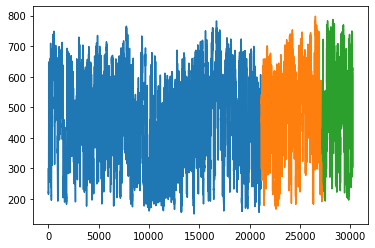

In [16]:
# check the train test split by plotting both

plt.plot(co2_train)
plt.plot(co2_val)
plt.plot(co2_test)
plt.show()

### Create walk forward split

In [17]:
n_val = co2_val.shape[0]
val_split = 8
val_len = n_val // val_split
assert( n_val % val_split == 0)
print('This is the length of the validation data set:', n_val)
print('This is the number of validation splits:', val_split)
print('This is the length of one validation split:', val_len)

This is the length of the validation data set: 6048
This is the number of validation splits: 8
This is the length of one validation split: 756


In [18]:
from sklearn.model_selection import TimeSeriesSplit
# get object that contains split indexes accorcing to the test lenght and the forecast period

#define forecast period
forecast_period = 24
tscv_val = TimeSeriesSplit(gap = 0, test_size= val_len, n_splits = val_split)
tscv_test = TimeSeriesSplit(gap = 0, test_size= forecast_period, n_splits = int(len(co2_test)/forecast_period))

In [19]:
for train_index, test_index in tscv_val.split(co2_train_val):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = features.values[train_index], features.values[test_index]
    y_train, y_test = co2.values[train_index], co2.values[test_index]

TRAIN: [    0     1     2 ... 21164 21165 21166] TEST: [21167 21168 21169 21170 21171 21172 21173 21174 21175 21176 21177 21178
 21179 21180 21181 21182 21183 21184 21185 21186 21187 21188 21189 21190
 21191 21192 21193 21194 21195 21196 21197 21198 21199 21200 21201 21202
 21203 21204 21205 21206 21207 21208 21209 21210 21211 21212 21213 21214
 21215 21216 21217 21218 21219 21220 21221 21222 21223 21224 21225 21226
 21227 21228 21229 21230 21231 21232 21233 21234 21235 21236 21237 21238
 21239 21240 21241 21242 21243 21244 21245 21246 21247 21248 21249 21250
 21251 21252 21253 21254 21255 21256 21257 21258 21259 21260 21261 21262
 21263 21264 21265 21266 21267 21268 21269 21270 21271 21272 21273 21274
 21275 21276 21277 21278 21279 21280 21281 21282 21283 21284 21285 21286
 21287 21288 21289 21290 21291 21292 21293 21294 21295 21296 21297 21298
 21299 21300 21301 21302 21303 21304 21305 21306 21307 21308 21309 21310
 21311 21312 21313 21314 21315 21316 21317 21318 21319 21320 21321 21

In [20]:
co2_train_val.shape, co2_test.shape, co2.shape

((27215,), (3024,), (30239,))

In [21]:
# check the number of splits for the forward validation
tscv_val.get_n_splits(), tscv_test.get_n_splits()

(8, 126)

In [22]:
# check if the tscv splits align with the test data set
assert(tscv_val.get_n_splits() == co2_val.shape[0] / val_len)
assert(tscv_test.get_n_splits() == co2_test.shape[0] / forecast_period)

### Walk forward Grid Search

In [23]:
# import possible base estimators
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR 
from sklearn.neighbors import KNeighborsRegressor

In [24]:
# define the grid for the grid search 
grid = {'base_estimator': [None],
          'n_estimators': [250,500,750,1000],
           'max_samples': [0.75,1.0,],
          'bootstrap': [True, False],
}

In [25]:
from sklearn.model_selection import GridSearchCV

In [26]:
features.columns

Index(['windon_forecast', 'windoff_forecast', 'solar_forecast',
       'prices_forecast', 'aggregated_generation_forecast', 'AT_import',
       'AT_export', 'CZ_import', 'CZ_export', 'DK_import', 'DK_export',
       'LU_import', 'LU_export', 'NL_import', 'NL_export', 'PL_import',
       'PL_export', 'CH_import', 'CH_export', 'co2_24_lag', 'co2_26_lag',
       'day_of_week_fri', 'day_of_week_mon', 'day_of_week_sat',
       'day_of_week_sun', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'hour_of_day_sin', 'hour_of_day_cos',
       'hour_of_year_sin', 'hour_of_year_cos'],
      dtype='object')

In [27]:
rf_cv = GridSearchCV(estimator=BaggingRegressor(n_jobs = 6), param_grid=grid, cv= tscv_val, scoring= 'neg_root_mean_squared_error', refit= False)
rf_cv.fit(features_train_val, co2_train_val)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=756),
             estimator=BaggingRegressor(n_jobs=6),
             param_grid={'base_estimator': [None], 'bootstrap': [True, False],
                         'max_samples': [0.75, 1.0],
                         'n_estimators': [250, 500, 750, 1000]},
             refit=False, scoring='neg_root_mean_squared_error')

In [98]:
# check the best estimator of the grid search
rf_cv.best_estimator_

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [28]:
# check the best parameters for the grid search
rf_cv.best_params_

{'base_estimator': None,
 'bootstrap': True,
 'max_samples': 0.75,
 'n_estimators': 750}

In [29]:
# ceck the best scor of the grid serach
rf_cv.best_score_

-41.80152616503804

In [31]:
# save grid search as csv
df = pd.DataFrame(rf_cv.cv_results_ )
df.to_csv('grid_search_bagging.csv')

In [32]:
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator,param_bootstrap,param_max_samples,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
0,17.596667,1.666706,2.442293,0.183417,None,True,0.75,250,"{'base_estimator': None, 'bootstrap': True, 'm...",-43.921109,-44.540141,-32.841050,-47.635617,-35.301557,-30.878894,-48.454206,-51.575688,-41.893533,7.310930,4
1,35.277434,3.854324,5.169776,0.351245,None,True,0.75,500,"{'base_estimator': None, 'bootstrap': True, 'm...",-44.246744,-44.472531,-32.531913,-47.774982,-34.491918,-31.026288,-48.714332,-51.341421,-41.825016,7.441853,2
2,54.484931,4.819445,8.185230,0.658177,None,True,0.75,750,"{'base_estimator': None, 'bootstrap': True, 'm...",-43.733230,-44.371162,-32.429603,-48.057146,-35.007466,-31.046098,-48.397668,-51.369837,-41.801526,7.367160,1
3,71.562805,6.657244,11.214326,0.849907,None,True,0.75,1000,"{'base_estimator': None, 'bootstrap': True, 'm...",-43.906725,-44.455779,-32.826199,-47.808394,-34.808068,-31.062987,-48.487247,-51.604699,-41.870012,7.357854,3
4,20.251602,1.392794,2.627536,0.079019,None,True,1.0,250,"{'base_estimator': None, 'bootstrap': True, 'm...",-44.060416,-44.666227,-32.613494,-48.024997,-34.870893,-31.377834,-48.676327,-51.650173,-41.992545,7.391841,8
5,39.554879,3.029581,4.865504,0.335074,None,True,1.0,500,"{'base_estimator': None, 'bootstrap': True, 'm...",-43.889686,-44.802125,-32.426351,-48.050331,-35.237934,-30.861543,-48.625744,-51.599295,-41.936626,7.462319,6
6,59.096158,4.839581,7.513007,0.450425,None,True,1.0,750,"{'base_estimator': None, 'bootstrap': True, 'm...",-43.980493,-44.324014,-32.706792,-48.511072,-34.680148,-30.840790,-48.708426,-51.525009,-41.909593,7.515424,5
7,78.054163,6.163583,11.394870,2.055895,None,True,1.0,1000,"{'base_estimator': None, 'bootstrap': True, 'm...",-44.041044,-44.398666,-32.574205,-48.320299,-34.987044,-30.898949,-48.454925,-51.866790,-41.942740,7.500996,7
8,23.012311,1.896828,2.621242,0.191714,None,False,0.75,250,"{'base_estimator': None, 'bootstrap': False, '...",-44.419469,-44.781411,-34.070135,-49.475273,-36.455688,-31.425223,-49.113277,-52.658557,-42.799879,7.365485,10
9,46.695270,3.920015,5.410228,0.137608,None,False,0.75,500,"{'base_estimator': None, 'bootstrap': False, '...",-44.403058,-45.134159,-33.418261,-50.051898,-36.470774,-31.166912,-49.425024,-52.621363,-42.836431,7.618665,12


In [33]:
import joblib

In [34]:
# save th grid search model
joblib.dump(rf_cv,'grid_search_bagging4.pkl')

['grid_search_bagging4.pkl']

### Walk forward validation

In [23]:
# Define the bagging regressor for the walk forward validation
# use best params from grid search
# {'base_estimator': None,
# 'bootstrap': True,
# 'max_samples': 0.75,
# 'n_estimators': 750}

model_bag = BaggingRegressor(base_estimator=None,bootstrap=True, max_samples= 0.75,
                 n_estimators=750, n_jobs=6, random_state = 42) 

In [24]:
# define the confidence interval for the prediction
alpha_low = 0.025
alpha_high = 0.975
ci_width = alpha_high - alpha_low
print('width of confidence interval is:', ci_width)

width of confidence interval is: 0.95


In [25]:
# check results on training set
# fit the model on training 
model_bag_fit = model_bag.fit(features_train, co2_train)

# make prediction on the training data
low_train, pred_train, upp_train = fun.predict_uncertaitny(model_bag, features_train.values, alpha_low, alpha_high)
report_train  = fun.evaluation(pred_train,low_train,upp_train, co2_train,alpha_low, alpha_high,n_features, 'Bagging Regression')
print(report_train)

MAE for Bagging Regression: 8.48 g_CO2/kWh
MAPE for Bagging Regression: 2.11 %
RMSE for Bagging Regression: 11.53 g_CO2/kWh
Pinball for lower Quantile Bagging Regression: 1.43 g_CO2/kWh
Pinball for higher Quantile Bagging Regression: 1.42 g_CO2/kWh
Interval Score Bagging Regression: 114.1805 g_CO2/kWh
Real Values insisde PI Bagging Regression: 100.0 %
R2 Bagging Regression: 99.32 %
Adjusted R2 Bagging Regression: 99.32 %


In [26]:
# Check error metrics on test set

pred_bag_val, report_bag_val, lower_bag_val, upper_bag_val = fun.walk_forward_shallow(tscv_val, model_bag, co2_train_val, features_train_val, co2_val,0.025,0.975, n_features, 'Baggging Regression',refit = True)
print(report_bag_val)
#[len(co2_test)-120 : len(co2_test)]

MAE for Baggging Regression: 33.07 g_CO2/kWh
MAPE for Baggging Regression: 7.580000000000001 %
RMSE for Baggging Regression: 42.33 g_CO2/kWh
Pinball for lower Quantile Baggging Regression: 2.88 g_CO2/kWh
Pinball for higher Quantile Baggging Regression: 2.55 g_CO2/kWh
Interval Score Baggging Regression: 184.4772 g_CO2/kWh
Real Values insisde PI Baggging Regression: 95.07 %
R2 Baggging Regression: 89.88000000000001 %
Adjusted R2 Baggging Regression: 89.83 %


In [27]:

pred_val_df = pd.DataFrame(pred_bag_val)
pred_val_df.to_csv('best_rf_mean_wf_val.csv')
pred_val_df.head() 

upper_val_df = pd.DataFrame(upper_bag_val)
upper_val_df.to_csv('best_rf_upper_wf_val.csv')
upper_val_df

lower_val_df = pd.DataFrame(lower_bag_val)
lower_val_df.to_csv('best_rf_lower_wf_val.csv')
lower_val_df

#mlp_test_report_01 = open("rf_val_report.txt", 'w')
#mlp_test_report_01.write(pred_rf_val)
#mlp_test_report_01.close()

,0
0,435.188803
1,396.503056
2,387.358068
3,386.555939
4,378.682136
...,...
6043,299.150584
6044,299.676373
6045,301.135607
6046,258.052368


In [28]:
# split the date data
date_val = date[int(n*train_ratio):int(n*val_ratio)]
date_test = date[int(n*val_ratio):]

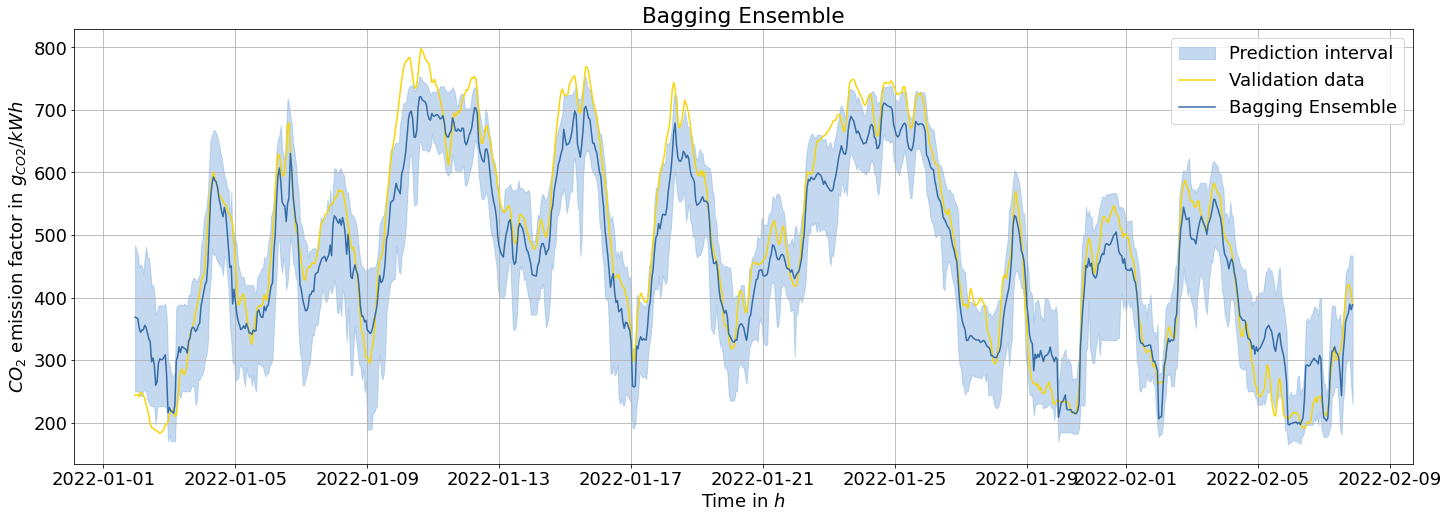

In [30]:
fun.plot_model_uncertainty2(co2_val, pred_val_df,lower_val_df ,upper_val_df, date_val, slice_start = '2022-01-01 23:00', slice_end =  '2022-02-15 23:00' , method = 'Bagging Ensemble')

### Walk forward testing

In [15]:
# Do walk forward validation of the best estimator accoring to the grid search

In [47]:
# Check error metrics on train set

# fit the model on training + validation data
model_bag_fit = model_bag.fit(features_train_val, co2_train_val)

# make prediction on the training data
#low_train_val, pred_train_val, upp_train_val = fun.predict_uncertaitny(model_bag, features_train_val.values, alpha_low, alpha_high)
#report_train_val  = fun.evaluation(pred_train_val,low_train_val,upp_train_val, co2_train_val,alpha_low, alpha_high,n_features, 'Bagging Regression')
#print(report_train_val)

In [48]:
# compute the feature importance
feature_importance = np.mean([
    tree.feature_importances_  for tree in model_bag_fit.estimators_
], axis = 0)

feature_importance

array([3.85139661e-01, 1.38961735e-02, 8.84941113e-02, 2.79182013e-01,
       1.36293163e-02, 4.79086296e-04, 2.76857953e-03, 2.83487323e-03,
       3.49110403e-03, 3.55235852e-03, 1.56186531e-03, 3.62576136e-03,
       2.51233834e-02, 3.13805862e-03, 2.25253228e-03, 8.29174796e-04,
       3.16399252e-03, 2.32939837e-03, 2.77468652e-03, 9.16120040e-02,
       4.52382582e-03, 4.26693313e-04, 4.15212271e-04, 1.99608411e-03,
       6.52004560e-04, 3.40259682e-04, 3.36597078e-04, 3.19578754e-04,
       1.36467728e-03, 2.64143636e-03, 8.95933488e-03, 4.81461618e-02])

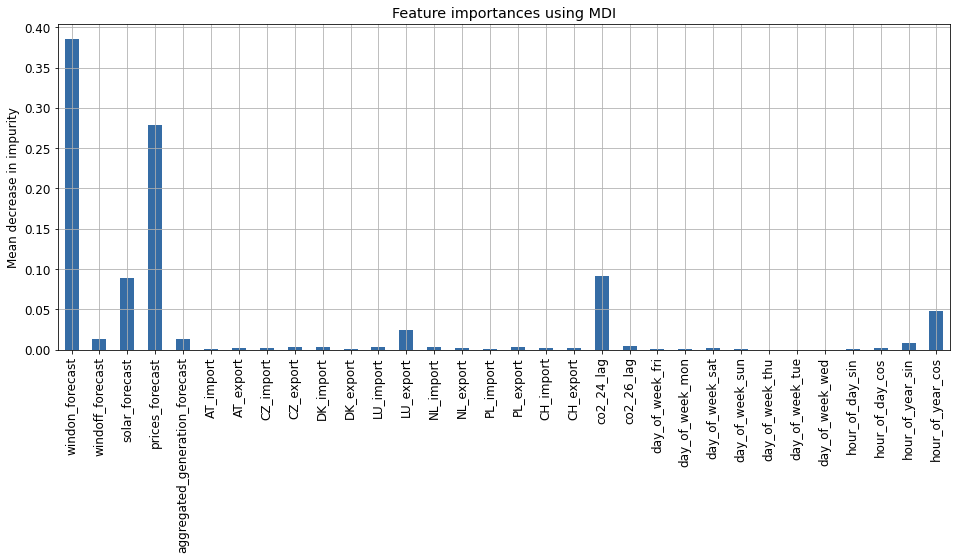

In [49]:
forest_importance = pd.Series(feature_importance, index= features.columns)
fun.plot_importance(forest_importance)

In [31]:
# Check error metrics on test set

pred_bag, report_bag, lower_bag, upper_bag = fun.walk_forward_shallow(tscv_test, model_bag, co2, features, co2_test,0.025,0.975,n_features, 'Baggging Regression',refit = True)
print(report_bag)
#[len(co2_test)-120 : len(co2_test)]

MAE for Baggging Regression: 33.59 g_CO2/kWh
MAPE for Baggging Regression: 7.24 %
RMSE for Baggging Regression: 41.92 g_CO2/kWh
Pinball for lower Quantile Baggging Regression: 2.92 g_CO2/kWh
Pinball for higher Quantile Baggging Regression: 2.21 g_CO2/kWh
Interval Score Baggging Regression: 182.0064 g_CO2/kWh
Real Values insisde PI Baggging Regression: 95.24 %
R2 Baggging Regression: 92.07 %
Adjusted R2 Baggging Regression: 91.99000000000001 %


In [32]:
pred_bagging_df = pd.DataFrame(pred_bag)
pred_bagging_df.to_csv('Bagging_test_results3.csv')
pred_bagging_df.head()


,0
0,385.735797
1,371.905854
2,361.634448
3,352.097886
4,344.270447


In [33]:
upper_test_df = pd.DataFrame(lower_bag)
upper_test_df.to_csv('Bagging_upper_wf_test3.csv')
upper_test_df

,0
0,266.627077
1,242.245771
2,242.245771
3,238.362076
4,235.643299
...,...
3019,370.823858
3020,384.288106
3021,437.837814
3022,445.413973


In [34]:
lower_test_df = pd.DataFrame(upper_bag)
lower_test_df.to_csv('Bagging_lower_wf_test2.csv')
lower_test_df

,0
0,452.804246
1,452.658230
2,443.176979
3,441.600489
4,441.600489
...,...
3019,555.049202
3020,596.133039
3021,620.211251
3022,626.362740


In [35]:
# split the date data
date_val = date[int(n*train_ratio):int(n*val_ratio)]
date_test = date[int(n*val_ratio):n]

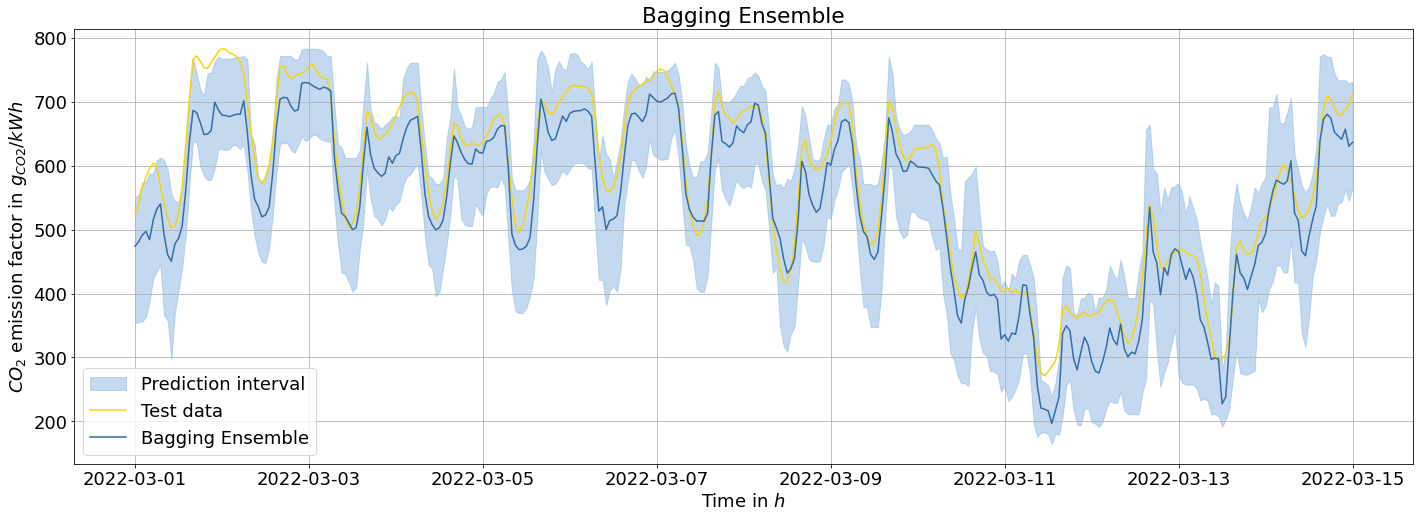

In [38]:
fun.plot_model_uncertainty(co2_test, pred_bagging_df,lower_test_df, upper_test_df, date_test, slice_start = '2022-03-01 00:00', slice_end =  '2022-03-15 00:00' , method = 'Bagging Ensemble')